# Template script for Koopman model learning (Python translation of MATLAB main).

In [1]:
from __future__ import annotations

import math
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat

from functions.general.lifting_function import lifting_function
from functions.stateSpaceModel.build_A_adaptive import build_A_adaptive
from functions.stateSpaceModel.build_B_numgrad_3D import build_B_numgrad_3D
from functions.stateSpaceModel.build_C import build_C
from functions.stateSpaceModel.compute_eigenf_adaptive import compute_eigenf_adaptive
from save_run_artifacts import save_run

In [42]:
def rk4_step(f: Callable[[float, np.ndarray, float], np.ndarray], t: float, x: np.ndarray, u: float, dt: float) -> np.ndarray:
    """Runge-Kutta 4 integrator for nonlinear system."""
    k1 = f(t, x, u)
    k2 = f(t, x + k1 * dt / 2.0, u)
    k3 = f(t, x + k2 * dt / 2.0, u)
    k4 = f(t, x + k3 * dt, u)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


def rk4_step_linear(Z: np.ndarray, A: np.ndarray, B: np.ndarray, u: float, dt: float) -> np.ndarray:
    """Runge-Kutta 4 integrator for linear state-space system."""
    def f_lin(vec: np.ndarray) -> np.ndarray:
        return A @ vec + B * u

    Y1 = f_lin(Z)
    Y2 = f_lin(Z + Y1 * dt / 2.0)
    Y3 = f_lin(Z + Y2 * dt / 2.0)
    Y4 = f_lin(Z + Y3 * dt)
    return Z + (dt / 6.0) * (Y1 + 2 * Y2 + 2 * Y3 + Y4)


# Generate initial conditions on the edges of a square region around the equilibrium point homogeneously spaced
def generate_initial_conditions_homogeneous(eq: np.ndarray, buffer: float, num_samples: int) -> np.ndarray:
    min_x1 = -buffer + eq[0]
    max_x1 = buffer + eq[0]
    min_x2 = -buffer + eq[1]
    max_x2 = buffer + eq[1]

    offset = buffer / num_samples
    x1 = np.vstack(
        (
            np.linspace(min_x1, max_x1 - offset, num_samples),
            min_x2 * np.ones(num_samples),
        )
    )
    x2 = np.vstack(
        (
            max_x1 * np.ones(num_samples),
            np.linspace(min_x2, max_x2 - offset, num_samples),
        )
    )
    x3 = np.vstack(
        (
            np.linspace(min_x1 + offset, max_x1, num_samples),
            max_x2 * np.ones(num_samples),
        )
    )
    x4 = np.vstack(
        (
            min_x1 * np.ones(num_samples),
            np.linspace(min_x2 + offset, max_x2, num_samples),
        )
    )
    return np.hstack((x1, x2, x3, x4))

# Generate initial conditions on the edges of a square region around the equilibrium point more densely for x1 in (1,3) and (-3,-1)
def generate_initial_conditions_dense_margins(eq: np.ndarray, buffer: float, num_samples: int) -> np.ndarray:
    min_x1 = -buffer + eq[0]
    max_x1 = buffer + eq[0]
    min_x2 = -buffer + eq[1]
    max_x2 = buffer + eq[1]

    offset = buffer / num_samples
    multiple = 3 # change this to increase/decrease density in the margins
    regions = 2*multiple + 1
    x1_part1 = np.linspace(min_x1, -1.0, multiple*(num_samples // (regions)), endpoint=False)
    x1_part2 = np.linspace(-1.0, 1.0, num_samples - 2*multiple*(num_samples // (regions)), endpoint=False)
    x1_part3 = np.linspace(1.0, max_x1, multiple*(num_samples // (regions)))
    x1_full = np.concatenate((x1_part1, x1_part2, x1_part3))

    x1 = np.vstack(
        (
            x1_full,
            min_x2 * np.ones(num_samples),
        )
    )
    x2 = np.vstack(
        (
            max_x1 * np.ones(num_samples),
            np.linspace(min_x2, max_x2 - offset, num_samples),
        )
    )
    x3 = np.vstack(
        (
            x1_full[::-1],
            max_x2 * np.ones(num_samples),
        )
    )
    x4 = np.vstack(
        (
            min_x1 * np.ones(num_samples),
            np.linspace(min_x2 + offset, max_x2, num_samples),
        )
    )
    return np.hstack((x1, x2, x3, x4))

# Generate initial conditions on the edges of a square region around the equilibrium point with x1 coordinates double the density than x2
def generate_initial_conditions_multiple_density(eq: np.ndarray, buffer: float, num_samples: int) -> np.ndarray:
    min_x1 = -buffer + eq[0]
    max_x1 = buffer + eq[0]
    min_x2 = -buffer-1 + eq[1]
    max_x2 = buffer+1 + eq[1]

    offset = buffer / num_samples
    multiple = 13 # x1 will have "multiple" the density than x2
    x1 = np.vstack(
        (
            np.linspace(min_x1, max_x1 - offset/multiple, num_samples * multiple),
            min_x2 * np.ones(num_samples * multiple),
        )
    )
    x2 = np.vstack(
        (
            max_x1 * np.ones(num_samples),
            np.linspace(min_x2, max_x2 - offset, num_samples),
        )
    )
    x3 = np.vstack(
        (
            np.linspace(min_x1 + offset/multiple, max_x1, num_samples * multiple),
            max_x2 * np.ones(num_samples * multiple),
        )
    )
    x4 = np.vstack(
        (
            min_x1 * np.ones(num_samples),
            np.linspace(min_x2 + offset, max_x2, num_samples),
        )
    )
    return np.hstack((x1, x2, x3, x4))

# Generate initial conditions on the edges of a square region around the equilibrium point more densely for x1 in (-1,1)
def generate_initial_conditions_dense_center(eq: np.ndarray, buffer: float, num_samples: int) -> np.ndarray:
    min_x1 = -buffer + eq[0]
    max_x1 = buffer + eq[0]
    min_x2 = -buffer + eq[1]
    max_x2 = buffer + eq[1]

    offset = buffer / num_samples
    x1_part1 = np.linspace(min_x1, -1.0, num_samples // 4, endpoint=False)
    x1_part2 = np.linspace(-1.0, 1.0, num_samples - 2*(num_samples // 4), endpoint=False)
    x1_part3 = np.linspace(1.0, max_x1, num_samples // 4)
    x1_full = np.concatenate((x1_part1, x1_part2, x1_part3))

    x1 = np.vstack(
        (
            x1_full,
            min_x2 * np.ones(num_samples),
        )
    )
    x2 = np.vstack(
        (
            max_x1 * np.ones(num_samples),
            np.linspace(min_x2, max_x2 - offset, num_samples),
        )
    )
    x3 = np.vstack(
        (
            x1_full[::-1],
            max_x2 * np.ones(num_samples),
        )
    )
    x4 = np.vstack(
        (
            min_x1 * np.ones(num_samples),
            np.linspace(min_x2 + offset, max_x2, num_samples),
        )
    )
    return np.hstack((x1, x2, x3, x4))

In [22]:
SAVE_ON = True  # set False to skip saving the learned model

# System parameters
# number of physical states used for modeling (x1,x2)
n_states = 2
# total simulated state dimension (augmented with the input-as-state x3)
n_total_states = 3
dt = 0.01
Tend = 5.0
time_span = np.arange(0.0, Tend, dt)
trajLen = len(time_span)
Ms = trajLen - 1
nEig = np.array([10, 10], dtype=int)
n_cc = np.floor(nEig / 2).astype(int)
h = 0.1

# System dynamics -- Van der Pol oscillator (from modelAnalysis.py)
#   dot x1 = x2
#   dot x2 = mu*(1 - x1^2)*x2 - x1 + (1 + a*x1^2)*tanh(b*u)
mu = 1.0
a = 0.5
b = 1.0

def f_u(t, x, u):
    # x is the augmented state [x1, x2, x3]
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    f1 = x2
    f2 = mu * (1.0 - x1 ** 2) * x2 - x1 + (1.0 + a * x1 ** 2) * math.tanh(b * x3)
    f3 = u  # dot x3 = u (input drives the third state)
    return np.array([f1, f2, f3], dtype=float)

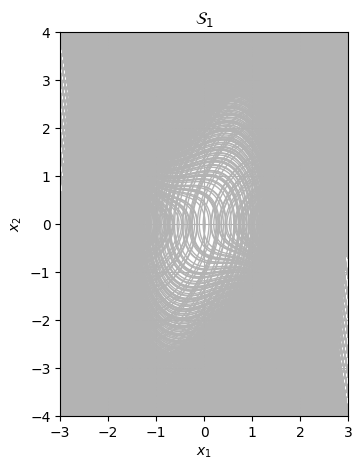

In [43]:
# equilibrium for the physical states (x1,x2)
eq = np.array([0.0, 0.0])
# gc kept as a 2-vector for compatibility with existing routines that
# expect an input-affine coefficient. The true input effect here is
# nonlinear: (1 + a*x1^2)*tanh(b*u).
gc = np.array([0.0, 0.0, 1.0])  # input affine coefficient (approx)

# Initial conditions
buffer = 3.0
init_cond = generate_initial_conditions_multiple_density(eq, buffer, num_samples=20)
# append initial values for the third (input) state (start at zero)
init_cond = np.vstack((init_cond, np.zeros((1, init_cond.shape[1]))))
Ntraj = init_cond.shape[1]

min_x1 = init_cond[0].min()
max_x1 = init_cond[0].max()
min_x2 = init_cond[1].min()
max_x2 = init_cond[1].max()

# Inputs: per-trajectory constant input applied to dot(x3)
inputs = np.arange(-10, 11, dtype=float)
n_inputs = len(inputs)

# Trajectory containers
Traj: list[list[np.ndarray]] = [[None for _ in range(Ntraj)] for _ in range(n_inputs)]
Traj_x1: list[list[np.ndarray]] = [[None for _ in range(Ntraj)] for _ in range(n_inputs)]
Traj_x2: list[list[np.ndarray]] = [[None for _ in range(Ntraj)] for _ in range(n_inputs)]
Traj_t: list[list[np.ndarray]] = [[None for _ in range(Ntraj)] for _ in range(n_inputs)]

plt.close("all")
fig, ax = plt.subplots()
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title(r"$\mathcal{S}_1$")
ax.set_xlim(min_x1, max_x1)
ax.set_ylim(min_x2, max_x2)
ax.grid(True)
ax.set_aspect("equal")

# Generate trajectories
for zz in range(n_inputs):
    for jj in range(Ntraj):
        # store the full simulated (augmented) state trajectory
        x_traj = np.zeros((n_total_states, trajLen), dtype=float)
        x_traj[:, 0] = init_cond[:, jj]

        ii = 0
        while (
            ii < Ms
            and min_x1 <= x_traj[0, ii] <= max_x1
            and min_x2 <= x_traj[1, ii] <= max_x2
        ):
            x_traj[:, ii + 1] = rk4_step(f_u, 0.0, x_traj[:, ii], inputs[zz], dt)
            ii += 1

        x_traj = x_traj[:, : ii + 1]
        ax.plot(x_traj[0, :], x_traj[1, :], color=(0.7, 0.7, 0.7), linewidth=1)

        # store trajectory augmented with the *input* as the third row
        # (MATLAB version appends the input value per sample). This makes
        # Traj entries shaped as (x1,x2,u) which is used later for building
        # interpolants in (x1,x2,u) space.
        traj_with_u = np.vstack((x_traj[0:2, :], inputs[zz] * np.ones((1, x_traj.shape[1]))))
        Traj[zz][jj] = traj_with_u
        Traj_x1[zz][jj] = traj_with_u[0, :]
        Traj_x2[zz][jj] = traj_with_u[1, :]
        Traj_t[zz][jj] = np.arange(traj_with_u.shape[1]) * dt

plt.tight_layout()
# Save the phase portrait so it is available even if the process is
# interrupted or the GUI backend closes figures on exit.
try:
    fig.savefig("phase_portrait.png", dpi=150)
except Exception:
    # non-fatal: continue if saving fails for any reason (headless, no write
    # permission, etc.)
    pass

# Vectorize data (physical states x1,x2 and input u are used for Koopman learning)
flat_traj = [traj for row in Traj for traj in row if traj is not None]
# include an extra list for the input (third row)
F_vec = [[] for _ in range(n_states + 1)]
for traj in flat_traj:
    F_vec[0].append(traj[0, :])
    F_vec[1].append(traj[1, :])
    F_vec[2].append(traj[2, :])

data_uncontrolled = np.vstack((np.hstack(F_vec[0]), np.hstack(F_vec[1]), np.hstack(F_vec[2])))


In [44]:
# Eigenvalues learning
lambdas1, lambdas_c1 = build_A_adaptive(Traj_x1, Traj_t, data_uncontrolled[0, :].T, dt, nEig[0], n_cc[0])
lambdas2, lambdas_c2 = build_A_adaptive(Traj_x2, Traj_t, data_uncontrolled[1, :].T, dt, nEig[1], n_cc[1])

lambdas = [lambdas1.flatten(), lambdas2.flatten()]
lambdas_c = np.concatenate((lambdas_c1, lambdas_c2)).flatten()

# Build matrices A and C
A = np.diag(np.concatenate((lambdas1.flatten(), lambdas2.flatten())))
Ac = np.diag(lambdas_c)
C = build_C(nEig, n_states)

`xtol` termination condition is satisfied.
Number of iterations: 193, function evaluations: 221, CG iterations: 928, optimality: 2.45e+06, constraint violation: 0.00e+00, execution time: 4.7e+05 s.
`xtol` termination condition is satisfied.
Number of iterations: 240, function evaluations: 254, CG iterations: 1252, optimality: 3.40e+07, constraint violation: 0.00e+00, execution time: 5.4e+05 s.


In [45]:
# Eigenfunctions learning
phi_vals, phi_hat = compute_eigenf_adaptive(lambdas, Traj_t, data_uncontrolled)
liftingFunction = lambda x: lifting_function(np.asarray(x, dtype=float).reshape(-1, 1), phi_hat)

zgstrf info 1930


/Users/zanubiadepasquale/DevelopmentProjects/LPV_Koopman_py/functions/stateSpaceModel/compute_eigenf_adaptive.py:71: MatrixRankWarning: Matrix is exactly singular
  g_vec = splinalg.spsolve(normal_mat.tocsc(), rhs)


In [46]:
# Simulation for prediction inspection
PREDICT_SINGLE_TRAJ = False
u_dt = lambda k: (-1.0) ** (round(k / 30))

if PREDICT_SINGLE_TRAJ:
    CHECK_ON_TRAINING = True
    dt_pred = 0.01

    # initial condition generator now returns the augmented state [x1,x2,x3]
    x0_fcn = lambda k: np.array(
        [
            min_x1 + (max_x1 - min_x1) * np.random.rand(),
            min_x2 + (max_x2 - min_x2) * np.random.rand(),
            0.0,
        ],
        dtype=float,
    )

    if CHECK_ON_TRAINING:
        Tpred = 1.0
        u = lambda t, k: 0.0
        title_string = "Prediction without input"
    else:
        Tpred = 2.0
        Amp = 1.0
        w = 10.0
        u = lambda t, k: Amp * math.sin(w * t)
        title_string = "Prediction with input"

    Npred = int(Tpred / dt_pred)
    kmax = 5

    for kk in range(kmax):
        x_initial = x0_fcn(kk)
        # lifting function expects the full augmented state (x1,x2,u) now
        # so pass the complete state vector (the input component is 0 for
        # the initial condition here).
        z0 = liftingFunction(x_initial).reshape(-1)

        # Xtrue stores the full augmented nonlinear trajectory; X_gra holds
        # the predicted physical states recovered from the Koopman model
        Xtrue = np.zeros((n_total_states, Npred + 1), dtype=float)
        X_gra = np.zeros((n_states, Npred + 1), dtype=float)
        Utrue = np.zeros(Npred + 1, dtype=float)
        Z_gra = np.zeros((np.sum(nEig), Npred + 1), dtype=complex)

        Z_gra[:, 0] = z0
        Xtrue[:, 0] = x_initial
        X_gra[:, 0] = np.real(C @ z0)
        Utrue[0] = u(0.0, kk)

        order = 4
        ii = 1
        while (
            ii <= Npred
            and (min_x1 + 0.2) <= X_gra[0, ii - 1] <= (max_x1 - 0.2)
            and (min_x2 + 0.2) <= X_gra[1, ii - 1] <= (max_x2 - 0.2)
        ):
            Utrue[ii] = u_dt(ii)
            Xtrue[:, ii] = rk4_step(f_u, 0.0, Xtrue[:, ii - 1], Utrue[ii], dt_pred)

            B_numgrad = build_B_numgrad_3D(h, phi_hat, np.concatenate((X_gra[:, ii-1], [Utrue[ii]])), nEig, gc)
            B_vec = np.asarray(B_numgrad).reshape(-1)
            Z_gra[:, ii] = rk4_step_linear(Z_gra[:, ii - 1], Ac, B_vec, Utrue[ii], dt_pred)
            X_gra[:, ii] = np.real(C @ Z_gra[:, ii])

            ii += 1

        time_ticks = np.linspace(0, ii - 1, 5)
        fig_pred, axes = plt.subplots(3, 1, figsize=(8, 8))

        axes[0].plot(Xtrue[0, :ii], linewidth=2, color="#001BFF", label=r"$x_1$")
        axes[0].plot(X_gra[0, :ii], linewidth=2, linestyle=":", color="magenta", label=r"$\hat x_1$")
        axes[0].legend(fontsize=12)
        axes[0].grid(True)
        axes[0].set_xticks(time_ticks)
        axes[0].set_xticklabels([f"{t*dt_pred:.2f}" for t in time_ticks])
        axes[0].set_ylabel(r"$x_1$")

        axes[1].plot(Xtrue[1, :ii], linewidth=2, color="#001BFF", label=r"$x_2$")
        axes[1].plot(X_gra[1, :ii], linewidth=2, linestyle=":", color="magenta", label=r"$\hat x_2$")
        axes[1].legend(fontsize=12)
        axes[1].grid(True)
        axes[1].set_xticks(time_ticks)
        axes[1].set_xticklabels([f"{t*dt_pred:.2f}" for t in time_ticks])
        axes[1].set_ylabel(r"$x_2$")

        axes[2].plot(Utrue[:ii], linewidth=2, color="#001BFF", label=r"$u$")
        axes[2].grid(True)
        axes[2].set_xticks(time_ticks)
        axes[2].set_xticklabels([f"{t*dt_pred:.2f}" for t in time_ticks])
        axes[2].set_xlabel("time [s]")
        axes[2].set_ylabel(r"$u$")

        fig_pred.suptitle(title_string)
        plt.tight_layout()

        # persist prediction figure to disk so it can be reviewed later
        try:
            fig_pred.savefig(f"prediction_{kk}.png", dpi=150)
        except Exception:
            pass

        # Show all figures and block until closed so plots are visible when
        # running the script from a terminal.
        plt.show()


In [47]:
# Save all interesting objects so replaying plots doesn't require
# re-running the learning stage.
artifacts = {
    "lambdas": lambdas,
    "lambdas_c": lambdas_c,
    "A": A,
    "Ac": Ac,
    "C": C,
    "nEig": nEig,
    "gc": gc,
    "h": h,
    #"liftingFunction": liftingFunction,
    # interpolation points (each row is a dimension)
    "interp_points": data_uncontrolled.T.astype(float),
    "phi_vals": phi_vals,
    # "phi_hat": phi_hat,
    # data used for learning
    "data_uncontrolled": data_uncontrolled,
    "Traj": Traj,
    "Traj_t": Traj_t,
    "Traj_x1": Traj_x1,
    "Traj_x2": Traj_x2,
    # to reproduce predictions
    "min_x1": min_x1,
    "max_x1": max_x1,
    "min_x2": min_x2,
    "max_x2": max_x2,
    "n_total_states": n_total_states,
    "n_states": n_states,
}

save_run("run_artifacts.pkl", artifacts)

In [1]:
BUILD_AUTONOMOUS_MESH = True

if BUILD_AUTONOMOUS_MESH:
    # Create matrix to hold prediction errors over grid
    error_matrix = np.zeros((len(np.arange(-3.0, 3.0 + 0.1, 0.1)), len(np.arange(-3.0, 3.0 + 0.1, 0.1))))

    # Generate mesh of autonomous prediction performance over state space grid
    for x1 in np.arange(-3.0, 3.0 + 0.1, 0.1):
        for x2 in np.arange(-3.0, 3.0 + 0.1, 0.1):
            CHECK_ON_TRAINING = True
            dt_pred = 0.01

            Tpred = 2.0
            u = lambda t, k: 0.0
            title_string = "Prediction without input"

            Npred = int(Tpred / dt_pred)

            x_initial = np.array([x1, x2, 0.0], dtype=float)
            # lifting function expects the full augmented state (x1,x2,u) now
            # so pass the complete state vector (the input component is 0 for
            # the initial condition here).
            z0 = liftingFunction(x_initial).reshape(-1)

            # Xtrue stores the full augmented nonlinear trajectory; X_gra holds
            # the predicted physical states recovered from the Koopman model
            Xtrue = np.zeros((n_total_states, Npred + 1), dtype=float)
            X_gra = np.zeros((n_states, Npred + 1), dtype=float)
            Utrue = np.zeros(Npred + 1, dtype=float)
            Z_gra = np.zeros((np.sum(nEig), Npred + 1), dtype=complex)

            Z_gra[:, 0] = z0
            Xtrue[:, 0] = x_initial
            X_gra[:, 0] = np.real(C @ z0)
            Utrue[0] = u(0.0, 0)

            order = 4
            ii = 1
            while (
                ii <= Npred
                and (min_x1 + 0.2) <= X_gra[0, ii - 1] <= (max_x1 - 0.2)
                and (min_x2 + 0.2) <= X_gra[1, ii - 1] <= (max_x2 - 0.2)
            ):
                Utrue[ii] = u_dt(ii)
                Xtrue[:, ii] = rk4_step(f_u, 0.0, Xtrue[:, ii - 1], Utrue[ii], dt_pred)

                B_numgrad = build_B_numgrad_3D(h, phi_hat, np.concatenate((X_gra[:, ii-1], [Utrue[ii]])), nEig, gc)
                B_vec = np.asarray(B_numgrad).reshape(-1)
                Z_gra[:, ii] = rk4_step_linear(Z_gra[:, ii - 1], Ac, B_vec, Utrue[ii], dt_pred)
                X_gra[:, ii] = np.real(C @ Z_gra[:, ii])

                ii += 1

                # Compute prediction error over trajectory
                error = np.linalg.norm(Xtrue[:2, :] - X_gra, ord=2)
                error_matrix[np.argmin(np.abs(np.arange(-3.0, 3.0 + 0.1, 0.1) - x1)), np.argmin(np.abs(np.arange(-3.0, 3.0 + 0.1, 0.1) - x2))] = error

NameError: name 'np' is not defined

In [ ]:
if BUILD_AUTONOMOUS_MESH:
    # Plot prediction error heatmap
    fig_error, ax_error = plt.subplots(figsize=(8, 8))
    cax = ax_error.imshow(error_matrix, origin="lower", cmap="viridis", extent=(-3.0, 3.0, -3.0, 3.0))
    # plot colorbar
    cbar = fig_error.colorbar(cax)
    # set plot title
    fig_error.suptitle('Prediction Error (L2 norm)')

    # persist prediction figure to disk so it can be reviewed later
    try:
        fig_error.savefig(f"autonomousPredMesh.png", dpi=150)
    except Exception:
        pass